# Introduction

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Our task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

# Data

We are provided with monet paintings both in JPG and TFRecords format as our training data. 

There are 300 monet images and 7038 JPG images

The image size is (256,256, 3)



# Metrics/Evaluation:

The final metric is FID score. It provides a similarity between real image and generated image

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory


from tqdm.notebook import tqdm
import itertools
import time
import shutil
import torch.optim as optim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Checking the number of GPU's

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('GPUs Available: ', strategy.num_replicas_in_sync)

GPUs Available:  2


# Getting the path of Monet JPG and Photo JPG

In [3]:
monet_path = "../input/gan-getting-started/monet_jpg/"
photo_path = "../input/gan-getting-started/photo_jpg/"

print("Number of monet paintings: {}".format(len(os.listdir(monet_path))))
print("Number of photos: {}".format(len(os.listdir(photo_path))))

Number of monet paintings: 300
Number of photos: 7038


# Getting the size of the images

In [4]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}")


print(f"Monet images:")
print_folder_statistics(monet_path)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(photo_path)
print("-" * 10)

Monet images:
shape: (256, 256, 3)
----------
Photo images:
shape: (256, 256, 3)
----------


# Loading Photos JPG and Monet JPG into a tensorflow  image dataset

In [5]:
image_size = (256, 256)
batch_size = 32

# Load Monet JPEG images from the directory
monet_ds = image_dataset_from_directory(
    '/kaggle/input/gan-getting-started/monet_jpg',
    label_mode=None,  # No labels are needed
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
).map(lambda x: (x / 127.5) - 1).prefetch(tf.data.experimental.AUTOTUNE).cache()

# Load Photo JPEG images from the directory
photo_ds = image_dataset_from_directory(
    '/kaggle/input/gan-getting-started/photo_jpg',
    label_mode=None,  # No labels are needed
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
).map(lambda x: (x / 127.5) - 1).prefetch(tf.data.experimental.AUTOTUNE).cache()

# Create iterators
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))


Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


# checking the shape

In [6]:
print(sample_monet.shape)
print(sample_photo.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


# Visualizing Monet and Sample Photos JPEG 

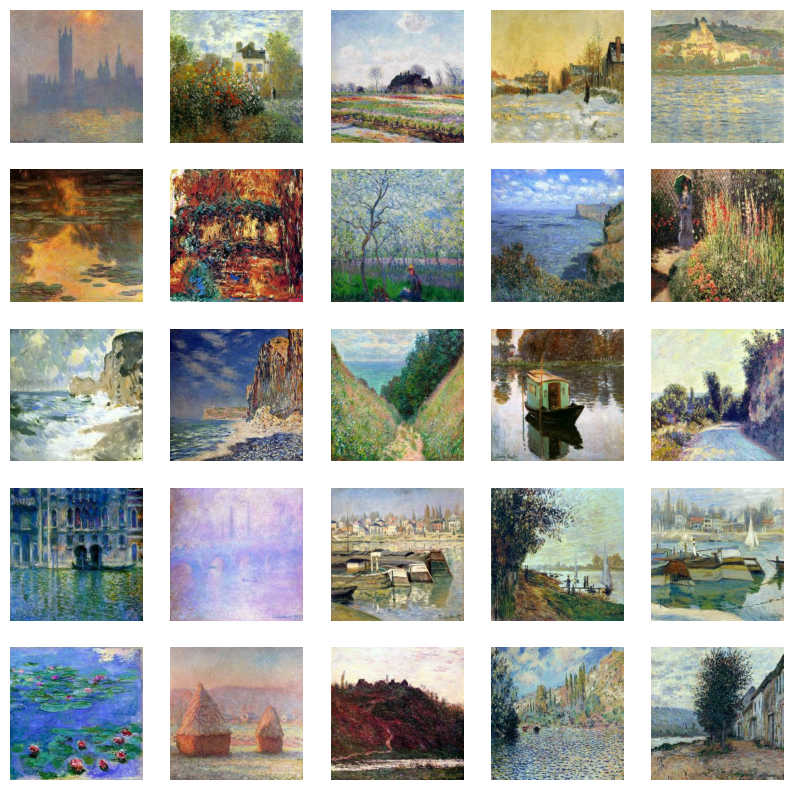

In [7]:
def visualize_images(example):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(example[i] * 0.5 + 0.5)
        plt.axis("off")
visualize_images(sample_monet)

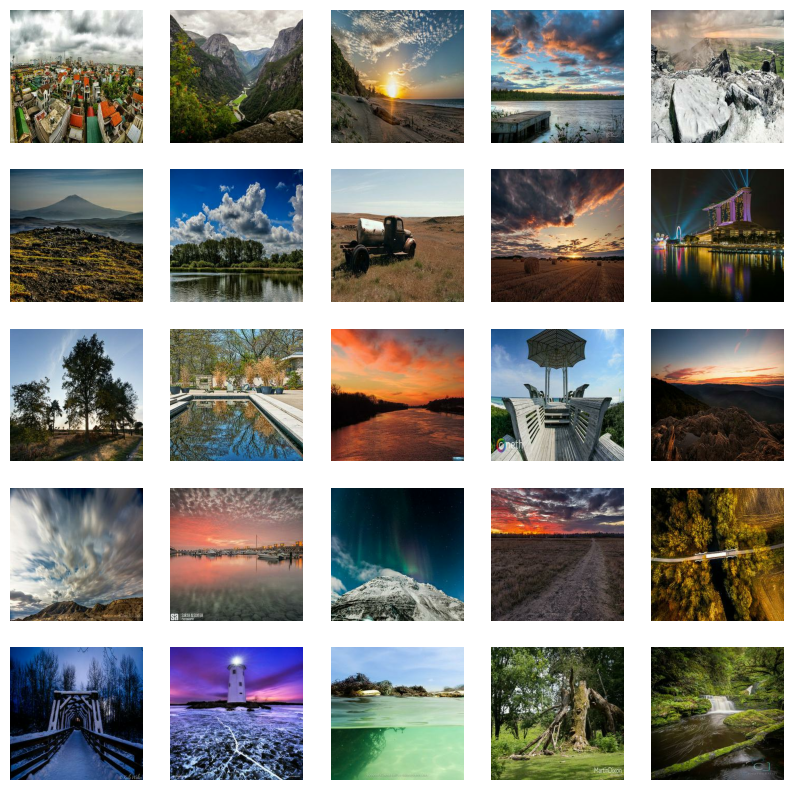

In [8]:
visualize_images(sample_photo)

# GAN's are Generative Adversarial Network. Generator tries to generate certain images while discriminator tries to differentiate fake and real images. We are using DCGAN to generate Monet Images 

# Creating a Generator Network

In [9]:
def create_generator():
    model = Sequential(name="Generator")
    
    n_nodes = 16 * 16 * 512 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_shape=(200,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))
   
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))
  
    return model


In [10]:
generator=create_generator()
generator.summary()


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (  (None, 131072)            26345472  
 Dense)                                                          
                                                                 
 Generator-Hidden-Layer-Res  (None, 16, 16, 512)       0         
 hape-1 (Reshape)                                                
                                                                 
 Generator-Hidden-Layer-2 (  (None, 32, 32, 256)       1179904   
 Conv2DTranspose)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 256)       0         
                                                                 
 Generator-Hidden-Layer-3 (  (None, 64, 64, 128)       295040    
 Conv2DTranspose)                                        

# Creating a Discriminator NEtwork

In [11]:
def create_discriminator():
    model = Sequential(name="Discriminator") # Model
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    return model


In [12]:
discriminator = create_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      896       
 -1 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      0         
 -Activation-1 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)        18496     
 -2 (Conv2D)                                                     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)      

# Creating loss Function for both Generator and Discriminator. Binary Corss Entropy is used (As there are 2 classes fake and real). 

In [13]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Leveraging both GPU's to run

In [14]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    generator = create_generator()  
    discriminator = create_discriminator()  
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Hyperparameters - Epochs, Batch Size, Noise and Shape of the image

In [15]:
EPOCHS = 1000
BATCH_SIZE = 32
noise_dim = 200
shape_dim = [256,256,3]

# Creating a DCGAN model which takes inputs as noise dim, Epochs, batch size, generator, discriminator and dataset

In [16]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):  
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
    
    @tf.function
    def train(self, images):
    
    # Create random noise vector
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate images use random noise vector
            generated_images = generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return (gen_loss + disc_loss) * 0.5
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim]) 
        predictions = self.generator.predict(noise)
        return predictions
        
    def generate_and_plot_images(self):      
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
            mean_loss = total_loss / num_batches

            if (epoch+1) % 500 == 0:                                  
                print ('Time for epoch {} is {} sec, total loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.generate_and_plot_images()


# Calling DCGAN Model

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 500 is 2.40576171875 sec, total loss is 2.2706360816955566
1/1 [==============================] - 1s 1s/step


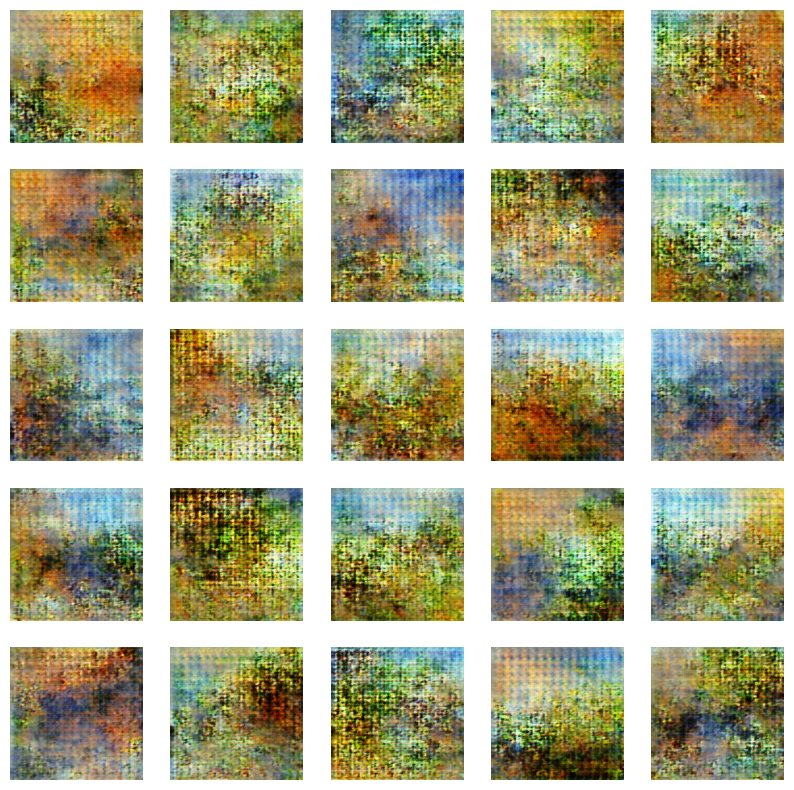

Time for epoch 1000 is 2.4029316902160645 sec, total loss is 1.556903600692749
1/1 [==============================] - 0s 144ms/step


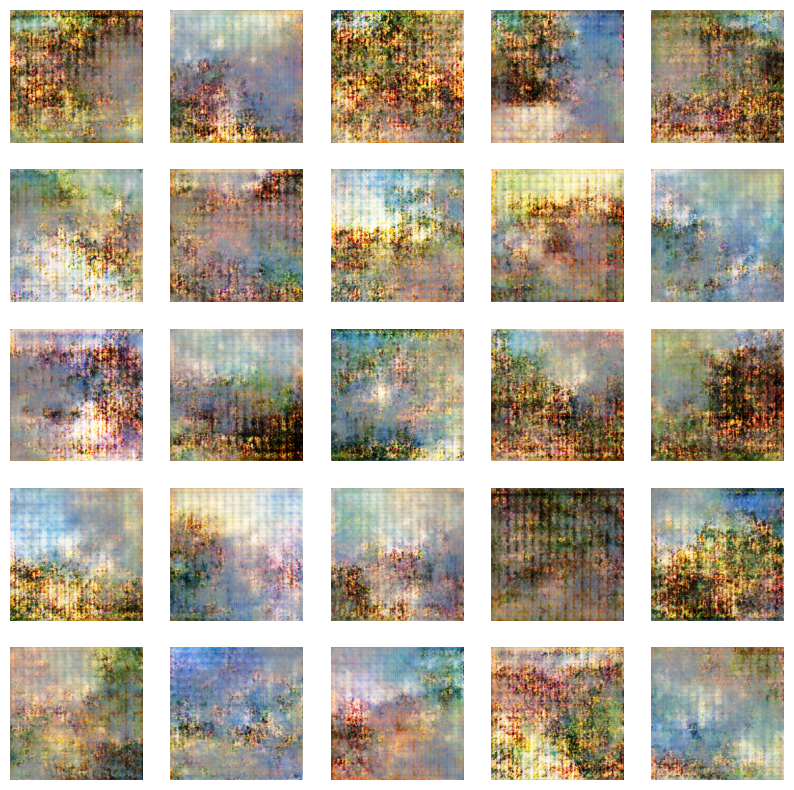

In [17]:
dcgan = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, monet_ds)
dcgan.train_loop()

# Creating a directory to save images

In [18]:
!mkdir ../images # To save the images

# Creating images 

In [19]:
with strategy.scope():
    for i in range(8000):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        img = generator.predict(noise)
        img = 0.5 * img + 0.5
        img = (img * 255).astype('uint8')
        img = Image.fromarray(img[0, :, :, :])
        img.save("../images/" + str(i) + ".jpg")

1/1 [==============================] - 0s 160ms/step


# Plotting images to see how the images have been generated

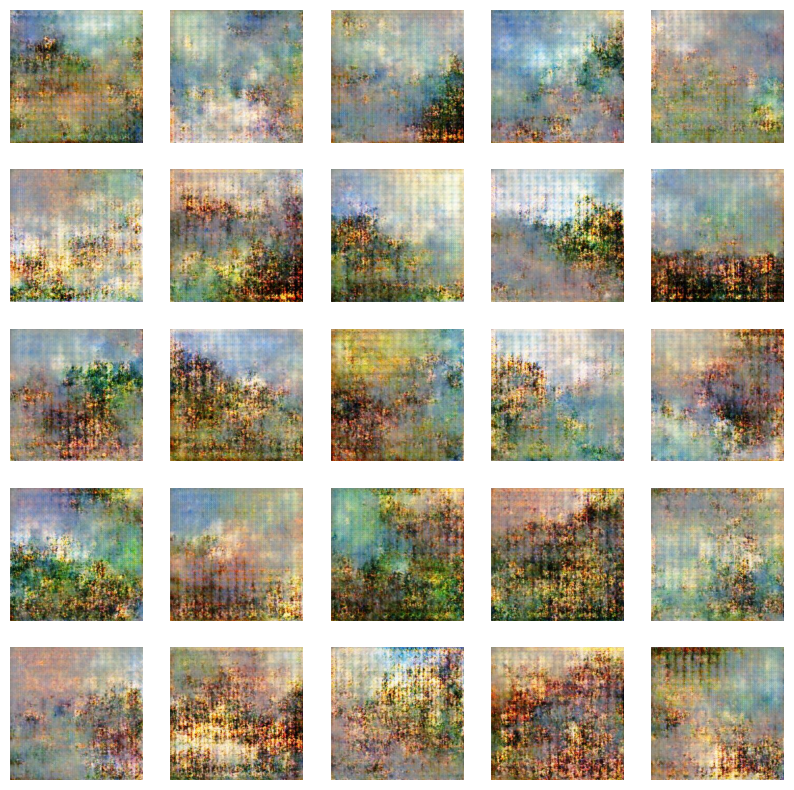

In [20]:
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(PIL.Image.open("../images/" + str(i) + ".jpg"))
    plt.axis('off')
plt.show()

# Moving it to the output folder to be submitted to the competition

In [21]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


'/kaggle/working/images.zip'

# Conclusion:

1. GAN's have become popular after Ian GoodFellow's 2014 Research 
2. GAN's can be used across various fields. GAN's can be used to augment images. 
3. In the current experiments, i did try noise as 100, noise as 50, but 200 seem to work well. 
4. There can be other hyperparameters such as number of layers in each of the generator and discriminator network
5. There are other GAN's such as CycleGAN, StyleGAN. These would generate much better results that the basic DCGAN network which we had seen over here